In [184]:
#import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp


In [185]:
# define Constants

# Gyro
# Radius
R = 1
# Height
H = 0.5
# Mass
M = 0.5
# Moment of inertia
I_1 = 0.25 * M * R **2 + M * H**2
I_2 = 0.25 * M * R **2 + M * H**2
I_3 = 0.5 * M * R **2

# Gravity
g = 9.8

# Initial conditions
THETA_0 = 0.5 * np.pi
PHI_0 = np.pi
PSI_0 = 0

D_THETA_0 = 0
D_PHI_0 = -0.5
D_PSI_0 = 10


In [186]:
def lagrangian(x, d_x, I, M, g, H):
    kinetic_energy = 0.5 * I[0] * (d_x[:,2] ** 2 * torch.sin(x[:,1]) ** 2 + d_x[:,1] ** 2) + 0.5 * I[2] * (d_x[:,2] * torch.cos(x[:,1]) + d_x[:,2]) ** 2
    potential_energy = M * g * H * torch.cos(x[:,1])
    return kinetic_energy - potential_energy

def lagrangian_equation(x, d_x, t, I, M, g, H):
    L = lagrangian(x, d_x, I, M, g, H).reshape(-1, 1)
    d_L_d_x = torch.autograd.grad(L, x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
    d_L_dd_x = torch.autograd.grad(L, d_x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
    d_L_dd_x_d_t = torch.autograd.grad(
    outputs=d_L_dd_x,
    inputs=t,
    grad_outputs=torch.ones_like(d_L_dd_x),
    create_graph=True,
    allow_unused=True
    )[0]
    return d_L_dd_x_d_t - d_L_d_x

def angular_momentum(d_x, I):
    return I[0] * d_x[0] ** 2 + I[1] * d_x[1] ** 2 + I[2] * d_x[2] ** 2

def eularian_transform(x, d_x):

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    omega_1 = phi_dot * torch.sin(theta) * torch.sin(psi) + theta_dot * torch.cos(psi)
    omega_2 = phi_dot * torch.cos(theta) * torch.cos(psi) - theta_dot * torch.sin(psi)
    omega_3 = phi_dot * torch.cos(theta) + psi_dot

    return torch.stack((omega_1, omega_2, omega_3), dim=1)

def moment_of_force(x, d_x, I, M, g, H):
    I_12 = I[0]
    I_3 = I[2]

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    omega = eularian_transform(x, d_x)

    omega_1 = omega[:,0]
    omega_2 = omega[:,1]
    omega_3 = omega[:,2]

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    
    epsilon = 1e-10
    condition = torch.abs(sin_theta) < epsilon
    signed_epsilon = torch.copysign(torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), sin_theta)
    signed_epsilon = torch.where(sin_theta == 0, torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), signed_epsilon)
    safe_sin_theta = torch.where(condition, signed_epsilon, sin_theta)

    #angular_acceleration_theta = (-I_12 * phi_dot * theta_dot * sin_theta + (I_12 - I_3) * omega_3 * theta_dot * sin_theta + M * g * H * sin_theta) / I_12
    #angular_acceleration_phi = (-I_12 * phi_dot * theta_dot * cos_theta + I_12 * theta_dot * psi_dot - (I_12 - I_3) * omega_3 * theta_dot) / I_12 * sin_theta
    #angular_acceleration_psi = (I_12 * phi_dot * theta_dot - I_12 * phi_dot * psi_dot * cos_theta + (I_12 - I_3) * omega_3 * theta_dot * cos_theta) / I_12 * sin_theta

    angular_acceleration_theta = phi_dot**2 * sin_theta * cos_theta - (I_3 / I_12) * phi_dot * sin_theta * omega_3 + (M * g * H / I_12) * sin_theta
    angular_acceleration_phi = (theta_dot / (I_12 * safe_sin_theta)) * (I_3 * omega_3 - 2 * I_12 * phi_dot * cos_theta)
    angular_acceleration_psi = phi_dot * theta_dot * sin_theta - angular_acceleration_phi * cos_theta

    return torch.stack((angular_acceleration_theta, angular_acceleration_phi, angular_acceleration_psi), dim=1)

In [187]:
LEARNING_RATE = 0.00001
BATCH_SIZE = 512
EPOCHS = 3000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TOTAL_TIME = 3

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 128)
        self.fc7 = nn.Linear(128, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = self.fc7(x)
        return x

model = Model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1000, verbose=True)

X_0 = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).reshape(3,1).to(DEVICE)
D_X_0 = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).reshape(3,1).to(DEVICE)
L_0 = torch.tensor([I_1 * D_THETA_0 ** 2, I_2 * D_PHI_0 ** 2 , I_3 * D_PSI_0 ** 2], dtype=torch.float32).reshape(3,1).to(DEVICE)
I = torch.tensor([I_1, I_2, I_3], dtype=torch.float32).reshape(3,1).to(DEVICE)

loss_data = []

def loss_function(output, time):

    output = torch.where(torch.abs(output) < 1e-4, torch.tensor(1e-4, device=output.device), output)

    output_gradient_theta = torch.autograd.grad(
        outputs=output[:,0],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,0]),
        create_graph=True
    )

    output_grident_2_theta = torch.autograd.grad(
        outputs=output_gradient_theta[0],
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_theta[0]),
        create_graph=True
    )

    output_gradient_phi = torch.autograd.grad(
        outputs=output[:,1],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,1]),
        create_graph=True
    )

    output_grident_2_phi = torch.autograd.grad(
        outputs=output_gradient_phi[0],
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_phi[0]),
        create_graph=True
    )

    output_gradient_psi = torch.autograd.grad(
        outputs=output[:,2],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,2]),
        create_graph=True
    )

    output_grident_2_psi = torch.autograd.grad(
        outputs=output_gradient_psi[0],
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_psi[0]),
        create_graph=True
    )

    output_gradient = torch.cat((output_gradient_theta[0].unsqueeze(1), output_gradient_phi[0].unsqueeze(1), output_gradient_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)
    output_gradient_2 = torch.cat((output_grident_2_theta[0].unsqueeze(1), output_grident_2_phi[0].unsqueeze(1), output_grident_2_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)

    # lagrangian_loss = nn.MSELoss()(lagrangian_equation(output, output_gradient, time, I, M, g, H), torch.zeros_like(lagrangian_equation(output, output_gradient, time)))

    initial_condition_loss = nn.MSELoss()(output[0], X_0) + nn.MSELoss()(output_gradient[0], D_X_0)

    # boundary_loss = nn.MSELoss()(torch.remainder(output[-3,:], 2 * np.pi), torch.zeros_like(output[-3:]))

    # angular_momentum_loss = nn.MSELoss()(angular_momentum(output_gradient, I), L_0)

    moment_of_force_loss = nn.MSELoss()(moment_of_force(output, output_gradient, I, M, g, H), output_gradient_2)

    loss_data.append([initial_condition_loss.item(), moment_of_force_loss.item()])

    return initial_condition_loss + 100 * moment_of_force_loss

for epoch in range(EPOCHS):
    
    model.train()
    time = np.linspace(0, TOTAL_TIME, BATCH_SIZE).reshape(-1, 1)
    time = torch.tensor(time, dtype=torch.float32, requires_grad=True).to(DEVICE)
    output = model(time)
    optimizer.zero_grad()
    loss = loss_function(output, time)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if epoch  % (EPOCHS / 10) == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}, Learning Rate: {scheduler.optimizer.param_groups[0]["lr"]}')

print("Training complete.")

Epoch 1/3000, Loss: 37.609683990478516, Learning Rate: 1e-05
Epoch 301/3000, Loss: 37.168399810791016, Learning Rate: 1e-05
Epoch 601/3000, Loss: 36.75387191772461, Learning Rate: 1e-05
Epoch 901/3000, Loss: 36.1865119934082, Learning Rate: 1e-05
Epoch 1201/3000, Loss: 35.37116241455078, Learning Rate: 1e-05
Epoch 1501/3000, Loss: 34.87958526611328, Learning Rate: 1e-05
Epoch 1801/3000, Loss: 34.46839141845703, Learning Rate: 1e-05
Epoch 2101/3000, Loss: 33.98701477050781, Learning Rate: 1e-05


KeyboardInterrupt: 

In [ ]:
def real_word_simulation(time, I, X_0, D_X_0):

  s_I_12 = I[0]
  s_I_3 = I[2]

  s_output = []

  s_theta = X_0[0]
  s_phi = X_0[1]
  s_psi = X_0[2]

  s_theta_dot = D_X_0[0]
  s_phi_dot = D_X_0[1]
  s_psi_dot = D_X_0[2]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot
  
  if abs(s_sin_theta) < 1e-10:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = 0
    s_psi_dot_dot = 0
  else:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
    s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_output.append([s_theta, s_phi, s_psi, s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  d_t = time[1] - time[0]

  time = time[:-1]

  for _ in time:

    s_theta = s_output[-1][0]
    s_phi = s_output[-1][1]
    s_psi = s_output[-1][2]

    s_theta_dot = s_output[-1][3]
    s_phi_dot = s_output[-1][4]
    s_psi_dot = s_output[-1][5]

    s_sin_theta = np.sin(s_theta)
    s_cos_theta = np.cos(s_theta)

    if abs(s_sin_theta) < 1e-5:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = 0
      s_psi_dot_dot = 0

    else:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
      s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

    s_output.append([s_theta + s_theta_dot * d_t, s_phi + s_phi_dot * d_t, s_psi + s_psi_dot * d_t, s_theta_dot + s_theta_dot_dot * d_t, s_phi_dot + s_phi_dot_dot * d_t, s_psi_dot + s_psi_dot_dot * d_t, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  return np.array(s_output)

def real_word_simulation_solve_ivp_fun(time, y, I, M, g, H):
  s_I_12 = I[0]
  s_I_3 = I[2]

  s_theta = y[0]
  s_phi = y[1]
  s_psi = y[2]

  s_theta_dot = y[3]
  s_phi_dot = y[4]
  s_psi_dot = y[5]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  
  epsilon = 1e-10
  if abs(s_sin_theta) < epsilon:
    s_safe_sin_theta = np.sign(s_sin_theta) * epsilon + (1 - np.sign(s_sin_theta) ** 2) * epsilon
    if abs(s_safe_sin_theta) < epsilon:
      s_safe_sin_theta = epsilon
  else:
    s_safe_sin_theta = s_sin_theta

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot

  s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
  s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
  s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_theta_dot_dot = s_phi_dot**2 * s_sin_theta * s_cos_theta - (s_I_3 / s_I_12) * s_phi_dot * s_sin_theta * s_omega_30 + (M * g * H / s_I_12) * s_sin_theta
  s_phi_dot_dot = (s_theta_dot / (s_I_12 * s_safe_sin_theta)) * (s_I_3 * s_omega_30 - 2 * s_I_12 * s_phi_dot * s_cos_theta)
  s_psi_dot_dot = s_phi_dot * s_theta_dot * s_sin_theta - s_phi_dot_dot * s_cos_theta

  return [s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot]

def real_word_simulation_solve_ivp(time, I, X_0, D_X_0, M, g, H):
  y = [X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]]
  y_0 = np.array([X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]])
  s_output = solve_ivp(real_word_simulation_solve_ivp_fun, [time[0], time[-1]], y_0, t_eval=time, args=(I, M, g, H), method='LSODA', rtol=1e-6, atol=1e-6)
  print(s_output.message)
  return np.array(s_output.y).T


The solver successfully reached the end of the integration interval.


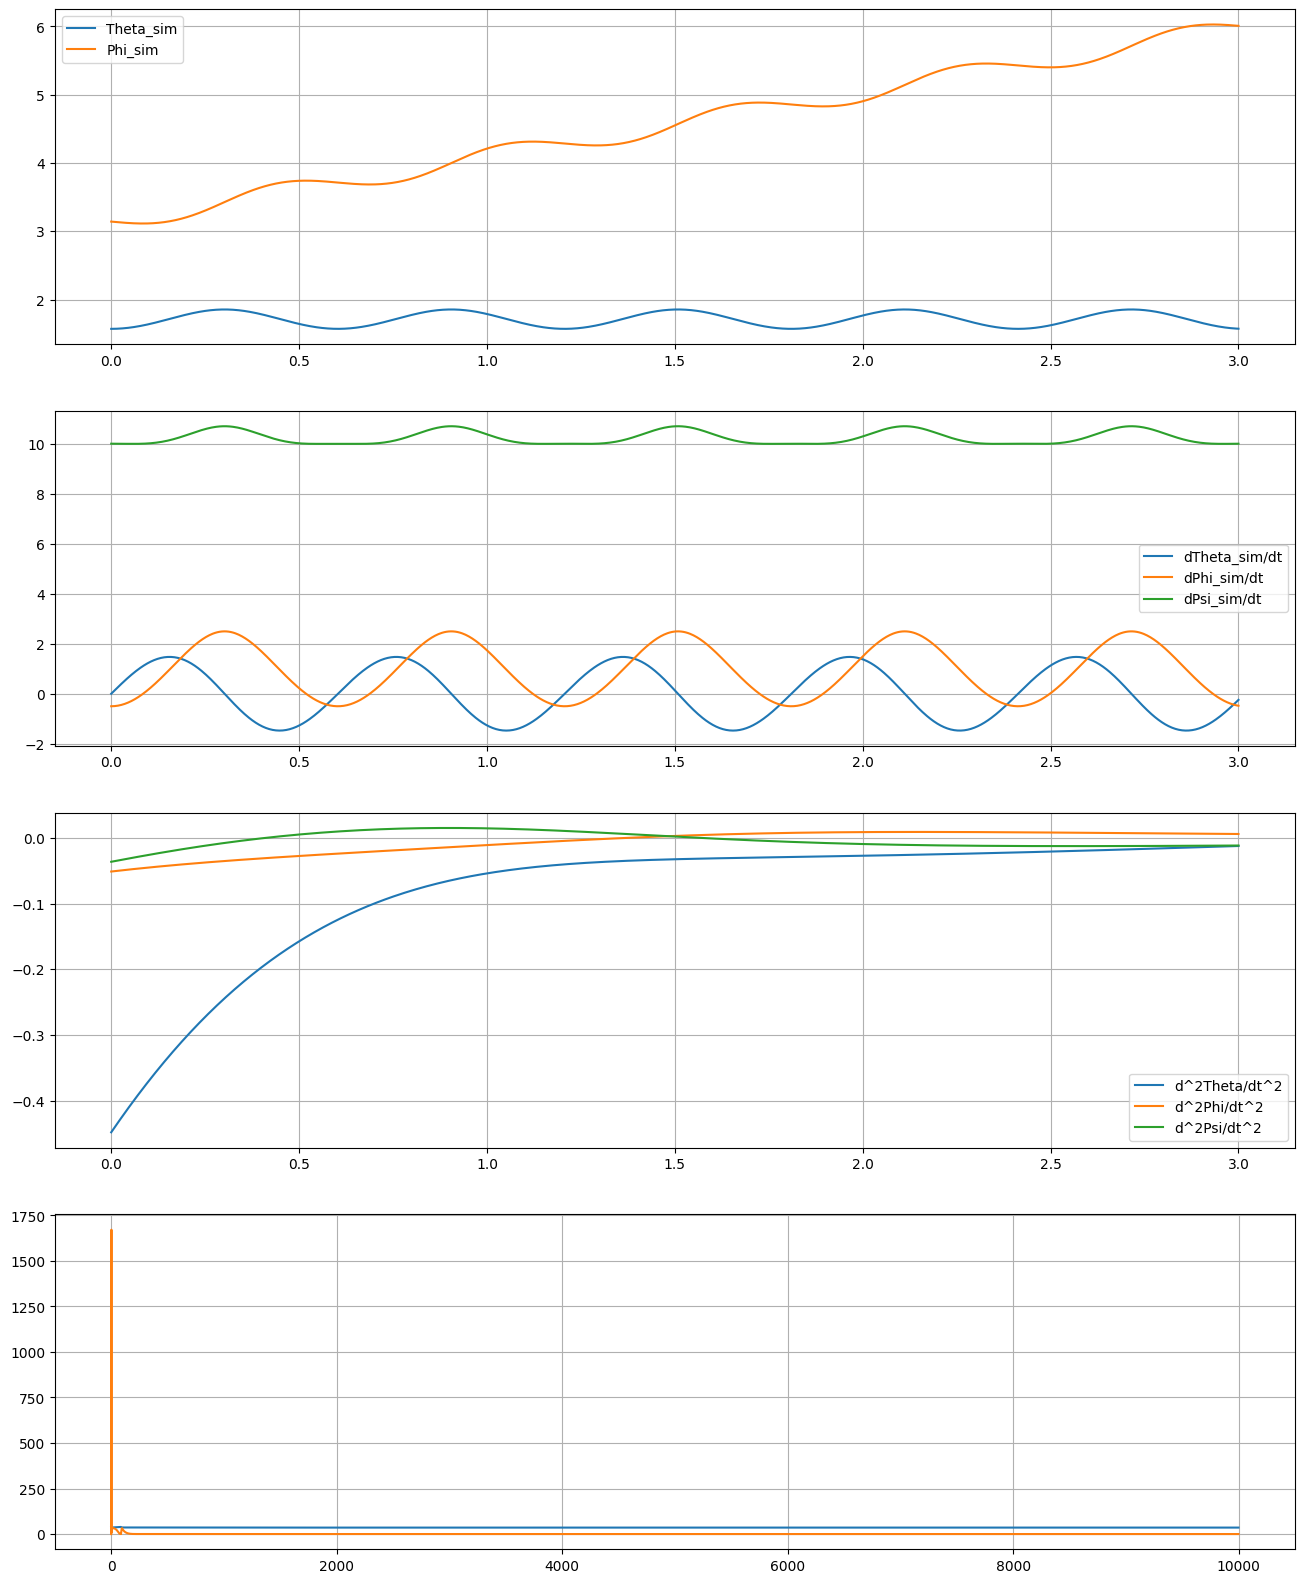

In [ ]:
time = np.linspace(0, TOTAL_TIME, BATCH_SIZE).reshape(-1, 1)
time = torch.tensor(time, dtype=torch.float32, requires_grad=True).to(DEVICE)

output = model(time)

output_gradient_theta = torch.autograd.grad(
    outputs=output[:,0],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,0]),
    create_graph=True
)

output_grident_2_theta = torch.autograd.grad(
    outputs=output_gradient_theta[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_theta[0]),
    create_graph=True
)

output_gradient_phi = torch.autograd.grad(
    outputs=output[:,1],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,1]),
    create_graph=True
)

output_grident_2_phi = torch.autograd.grad(
    outputs=output_gradient_phi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_phi[0]),
    create_graph=True
)

output_gradient_psi = torch.autograd.grad(
    outputs=output[:,2],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,2]),
    create_graph=True
)

output_grident_2_psi = torch.autograd.grad(
    outputs=output_gradient_psi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_psi[0]),
    create_graph=True
)

output_gradient = torch.cat((output_gradient_theta[0].unsqueeze(1), output_gradient_phi[0].unsqueeze(1), output_gradient_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)
output_gradient_2 = torch.cat((output_grident_2_theta[0].unsqueeze(1), output_grident_2_phi[0].unsqueeze(1), output_grident_2_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)

output_gradient = output_gradient.detach().cpu().numpy()
output_gradient_2 = output_gradient_2.detach().cpu().numpy()

time = time.detach().cpu().numpy()
output = output.detach().cpu().numpy()

time_sim = np.linspace(0, TOTAL_TIME, 1000)

X_0 = np.array([THETA_0, PHI_0, PSI_0])
D_X_0 = np.array([D_THETA_0, D_PHI_0, D_PSI_0])
I = np.array([I_1, I_2, I_3])
# output_sim = real_word_simulation(time_sim, I, X_0, D_X_0)
output_sim = real_word_simulation_solve_ivp(time_sim, I, X_0, D_X_0, M, g, H)

plt.figure(figsize=(16, 20))

plt.subplot(4, 1, 1)
#plt.plot(time, output[:, 0], label='Theta')
#plt.plot(time, output[:, 1], label='Phi')
#plt.plot(time, output[:, 2], label='Psi')
plt.plot(time_sim, output_sim[:, 0], label='Theta_sim')
plt.plot(time_sim, output_sim[:, 1], label='Phi_sim')
#plt.plot(time_sim, output_sim[:, 2], label='Psi_sim')
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
#plt.plot(time, output_gradient[:, 0], label='dTheta/dt')
#plt.plot(time, output_gradient[:, 1], label='dPhi/dt')
#plt.plot(time, output_gradient[:, 2], label='dPsi/dt')
plt.plot(time_sim, output_sim[:, 3], label='dTheta_sim/dt')
plt.plot(time_sim, output_sim[:, 4], label='dPhi_sim/dt')
plt.plot(time_sim, output_sim[:, 5], label='dPsi_sim/dt')
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time, output_gradient_2[:, 0], label='d^2Theta/dt^2')
plt.plot(time, output_gradient_2[:, 1], label='d^2Phi/dt^2')
plt.plot(time, output_gradient_2[:, 2], label='d^2Psi/dt^2')
plt.legend()
plt.grid()

loss_data = np.array(loss_data)
initial_condition_loss_data = loss_data[:,0]
moment_of_force_loss_data = loss_data[:,1]

plt.subplot(4, 1, 4)
plt.plot(initial_condition_loss_data, label="Initial Condition Loss")
plt.plot(moment_of_force_loss_data, label="Moment of Force Loss")
plt.grid()

plt.show()